In [12]:
# importing the libraries
import os

from tqdm import tqdm
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import folium
import matplotlib.pyplot as plt

# Don't worry about this - just for compatibility
register_matplotlib_converters()

# These are path to the covid-19 cases, deaths file.
COVID19_PATH = "data/raw_data/covid-19-state-level-data.csv"
GOOGLE_MOBILITY_PATH = 'data/raw_data/us-mobility.csv'

## Section 1: Data Loading, Integration and Preprocessing 

In [ ]:
# Here we load the state level Covid 19 dataset
covid19_df = pd.read_csv(COVID19_PATH, index_col=0)

# Here we load the mobility data
google_mobility_df = pd.read_csv(GOOGLE_MOBILITY_PATH, index_col=0)

In [2]:
# Let's see COVID-19 cases data
covid19_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [3]:
# Let's see mobility data
google_mobility_df.head()

,state,county,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,Total,Total,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,Total,Total,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,Total,Total,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [4]:
# Get only total data

# Get indexes of Dataframe where county='Total' in mobility dataset.
# When county='Total' we get the Roll Up of the data
filter_index = google_mobility_df['county'] == 'Total'
# Filter only the Total
google_mobility_df = google_mobility_df[filter_index]

# Lets see the dataframe with state level (i.e. Total County) mobility information for each day
google_mobility_df.head()

,state,county,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Total,Total,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,Total,Total,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,Total,Total,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,Total,Total,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,Total,Total,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [5]:
# We have to integrate the datasheets to match dates and sates of each row from `covid19_df` to `google_mobility_df`.
# While doing that just keep a record of number of instances in 
#   covid-19 cases dataset that matched with a mobility record.

c_missing, c_found = 0, 0
records = []
# iterate each row of COVID-19 cases data
for ix, row in tqdm(list(covid19_df.iterrows())):
    # Try to get mapping record from the mobility data
    data = google_mobility_df[(google_mobility_df['date'] == row['date']) & 
                              (google_mobility_df['state'].str.lower() == row['state'].lower())]
    # If there are no available mobility record for the same day and same state as the record
    #  it is considered that mobility data is missing 
    if len(data) == 0:
        c_missing += 1
    # else it is found and we can add it to our dataset
    else:
        c_found += 1
        # you have to select all columns after thrid column and take the mean. 
        # You can get the first available value or mean. 
        #   (essentially you are removing first three columns of selected data)
        # Assuming some mobility data 
        #   may be duplicated (i.e. len(data) > 1) it is better to take average.
        data = data.iloc[:,3:].mean().to_dict()
        # Add the meta-columns (date and state), cases and deaths columns to new `data` dict struct.
        data.update(row.to_dict())
        # Add data dict to records 
        #   (i.e. this will add a row containing columns: date, state, cases, deaths, and mobility features)
        records.append(data)

# Convert records to a dataframe
df = pd.DataFrame(records)

print('Missing: {}, Found: {}'.format(c_missing, c_found))

df.head()

100%|██████████| 8154/8154 [00:35<00:00, 230.73it/s]

Missing: 802, Found: 7352


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,date,state,fips,cases,deaths
0,3.0,2.0,13.0,3.0,-1.0,0.0,2020-02-15,Arizona,4,1,0
1,1.0,1.0,19.0,1.0,-1.0,0.0,2020-02-15,California,6,7,0
2,4.0,3.0,10.0,3.0,3.0,-1.0,2020-02-15,Illinois,17,2,0
3,2.0,-4.0,0.0,3.0,-2.0,0.0,2020-02-15,Massachusetts,25,1,0
4,3.0,3.0,12.0,3.0,1.0,-1.0,2020-02-15,Texas,48,2,0


In [6]:
# What are the states that we are considering?

# Gets the set of unique states in the dataset
states = set(df['state'])

len(states)

51

In [7]:
# What is the range of dates that we have the data for?

df = df.assign(date=pd.to_datetime(df['date']))

min(df['date']), max(df['date'])

(Timestamp('2020-02-15 00:00:00'), Timestamp('2020-07-25 00:00:00'))

In [8]:
# Now since there can be missing data in the middle we have to collect these if any. So we iterate all possible 
# conmbinations of states and dates in the dataset

records = []
errors = []

c_missing = 0
for state in tqdm(set(df['state'])):
    for date in pd.date_range(min(df['date']), max(df['date'])):
        data = df[(df['date'] == date) & (df['state'] == state)]
        if len(data) == 0:
            # We dont have a record for one state on a day  
            c_missing += 1
            records.append({
                'date': date,
                'state': state,
            })
        else:
            if len(data) > 1:
                # show an error if there are more than one record for one state on the same day                
                errors.append(len(data))
                print('ERROR: found more than one record')
            data = data.drop(['date', 'state'], axis=1).mean().to_dict()
            data.update({
                'date': date,
                'state': state,
            })
            records.append(data)

print('There are {} missing records.'.format(c_missing))
print('There are {} matching records for priod {} to {}.'.format(len(records), min(df['date']), max(df['date'])))



100%|██████████| 51/51 [00:24<00:00,  2.11it/s]

There are 910 missing records.
There are 8262 matching records for priod 2020-02-15 00:00:00 to 2020-07-25 00:00:00.


In [9]:
df_0 = pd.DataFrame(records)

# Fill na with zero since it is undetermined and most of wich appear before COVID-19 perid.
df_0 = df.fillna(0)

df_0.head()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,date,state,fips,cases,deaths
0,3.0,2.0,13.0,3.0,-1.0,0.0,2020-02-15,Arizona,4,1,0
1,1.0,1.0,19.0,1.0,-1.0,0.0,2020-02-15,California,6,7,0
2,4.0,3.0,10.0,3.0,3.0,-1.0,2020-02-15,Illinois,17,2,0
3,2.0,-4.0,0.0,3.0,-2.0,0.0,2020-02-15,Massachusetts,25,1,0
4,3.0,3.0,12.0,3.0,1.0,-1.0,2020-02-15,Texas,48,2,0


In [13]:
# Save the data in file
OVERWRITE = False

if OVERWRITE or not os.path.exists('data/processed_data/covid-19-state-level.csv'):
    df_0.to_csv('data/processed_data/covid-19-state-level.csv')
else:
    print('Path already exist. Please change variable `OVERWRITE` to true if you want to overwrite.')

Path already exist. Please change variable `OVERWRITE` to true if you want to overwrite.


## Section 2: Data Visualization

### Distribution of Total Number of COVID-19 cases amoung states

In [41]:
# Select maximum cases for each state
state_data = df.groupby('state')['cases'].max().to_frame()

# Make a new column cases_p that contain percentage of cases out of total cases in USA.
state_data = state_data.assign(cases_p=state_data['cases'] / state_data['cases'].sum())

# sort values by the number of cases in each state in decending order
#   (i.e. the top ones are states with macimum number of cases)
state_data = state_data.sort_values(by=['cases'], ascending=False).reset_index()

state_data.assign(cases_p = (state_data['cases_p'] * 100).round(1)).rename({'cases_p':'%'}, axis=1).head(6)

,state,cases,%
0,California,453327,10.9
1,New York,415911,10.0
2,Florida,414503,9.9
3,Texas,391609,9.4
4,New Jersey,180778,4.3
5,Illinois,171669,4.1


- Lets try to plot above in a map to do that first we need to convert state names to state code in file `./resources/us-state-codes.csv`

In [15]:
state_codes = {row.State: row.Abbreviation for row in pd.read_csv('./resources/us-state-codes.csv').itertuples()}

# Add column `state_code` to `state_data` dataframe
# state_data['state'] ; <- this selects the column state from `state_data` dataframe
#   .apply(lambda x: state_codes[x]) ; <- for each state this maps state to state code and returns list of codes
state_data = state_data.assign(state_code=state_data['state'].apply(lambda x: state_codes[x]))

state_data

,state,cases,cases_p,state_code
0,California,453327,0.108602,CA
1,New York,415911,0.099638,NY
2,Florida,414503,0.099301,FL
3,Texas,391609,0.093816,TX
4,New Jersey,180778,0.043308,NJ
5,Illinois,171669,0.041126,IL
6,Arizona,160055,0.038344,AZ
7,Georgia,151262,0.036237,GA
8,Massachusetts,115268,0.027614,MA
9,North Carolina,111366,0.026680,NC


In [16]:
# Use folium library to draw a choropleth map of COVID-19 cases till time {max_date=07-25-2020} indicated

state_geo = './resources/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

# Get the latest date we have
max_date = df['date'].max()

folium.Choropleth(
    geo_data=state_geo,
    name='Total COVID-19 Cases',
    data=state_data,
    columns=['state_code', 'cases_p'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Number of COVID-19 Cases till {} (%)'.format(max_date)
).add_to(m)

folium.LayerControl().add_to(m)

m

### Variation of new daily cases over time in 6 states with maximum COVID-19 cases

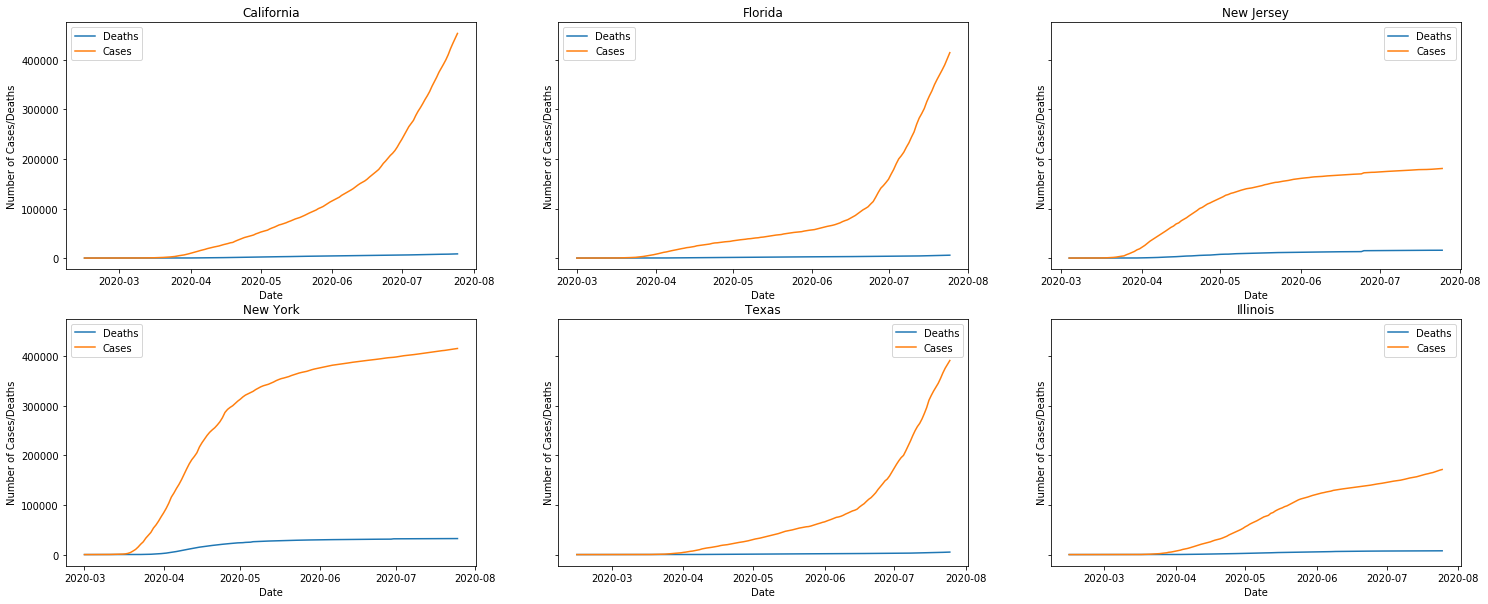

In [33]:
# Plot multiple plots in same figure
fig, axs = plt.subplots(2, 3, figsize=(25, 10), sharey=True)

# For top five state do...
for i, state in enumerate(state_data[:6]['state']):
    # calculate diference between two consecative dates to get the number of new cases
    y_dealths = df[df.state==state]['deaths'].reset_index(drop=True)
    y_cases = df[df.state==state]['cases'].reset_index(drop=True)

    x_date = df[df.state==state]['date']

    axs[i % 2][i // 2].plot(x_date, y_dealths, label='Deaths')
    axs[i % 2][i // 2].plot(x_date, y_cases, label='Cases')
    axs[i % 2][i // 2].set_ylabel('Number of Cases/Deaths')
    axs[i % 2][i // 2].set_xlabel('Date')
    axs[i % 2][i // 2].set_title(state)
    axs[i % 2][i // 2].legend()
    
plt.show()